In [1]:
#import relevant libraries and modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import signal
from scipy.fft import rfft, rfftfreq
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
def convert_to_temperature(pixel_avg):
    """
    Converts pixel value (mean) to temperature (fahrenheit) depending upon the camera hardware
    """
    #normalizing pixel avg
    norm = pixel_avg/255
    #create temperature range vector
    temp = np.linspace(38,105,10000)
    #create colormap
    cmap = cm.get_cmap('gray',10000)
    #create colormap range vector
    x = cmap(range(10000))
    #taking single channel
    x = x[:,0]
    #find difference array
    difference_array = np.absolute(x-norm)
    #find index of nearest value to norm in x
    index = difference_array.argmin()
    #return temp corresponding to pixel_avg
    return  temp[index]

In [3]:
def process_frame(frame,noses):
    mean = 0
    # loop for noses in the frame
    for x,y,w,h in noses:
        #cropping image of nose
        cropped_image = frame[int(y):int(y+h), 
                      int(x):int(x+w)]
        # change cropped image from bgr to Gray
        nose_frame = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        heatmap_gray = cv2.cvtColor(nose_frame, cv2.COLOR_RGB2GRAY)

        # Binary threshold
        _, binary_thresh = cv2.threshold(heatmap_gray, 135, 255,cv2.THRESH_BINARY)

        # Image opening: Erosion followed by dilation
        kernel = np.ones((3, 3), np.uint8)
        image_erosion = cv2.erode(binary_thresh, kernel, iterations=1)
        image_opening = cv2.dilate(image_erosion, kernel, iterations=1)
        #calculating the temperature
        mean = convert_to_temperature(cv2.mean(cropped_image,mask = image_opening)[0])
    return mean
   

In [4]:
#capture video
cap = cv2.VideoCapture(r'C:\Users\this pc\Documents\Imager Data\1.wmv')
#calculate number of frames
frame_number = cap.get(cv2.CAP_PROP_FRAME_COUNT)
#calculate frame rate
fps = cap.get(cv2.CAP_PROP_FPS)
#calculate Sampling Time
ts = round(1/fps,2)
#create the time vector for video duration
t = np.arange(0,int(frame_number/fps),ts)
#Initiazing Classifier object
nose_cascade = cv2.CascadeClassifier('cascade.xml')
# create empty list to store temperature in each frame
amplitude = []
#loop to read each video frame
while True:
    success, frame = cap.read()
    #break condition for loop if video is finished
    if not success:
        break
    #convert the frame into gray
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #detect the noses and return the array of tuple consiting x,y,w,h of the bounding box
    noses = nose_cascade.detectMultiScale(gray, 1.1, 4)
    # append the temperature in amplitude array for each frame
    amplitude.append(process_frame(frame,noses))
    #draw the rectangle around the nose 
    for x,y,w,h in noses:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
    cv2.imshow('img',frame)
    #keyboard break condition for loop
    if cv2.waitKey(int(ts*1000))& 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [5]:
#slicing amplitude array to the same size as time array
amplitude = amplitude[0:np.shape(t)[0]]

In [6]:
#for Interpolation create empty arrays of amplitude values not zero,of time corresponding to those values and
#of time on which amplitude has values zero
new_amp = []
new_t = []
x = []
#loop for filling values in empty array
for i in range(len(amplitude)):
    if amplitude[i] != 0:
        new_amp.append(amplitude[i])
        new_t.append(t[i])
    else:
        x.append(t[i])
# using numpy interpolation function returns values y correspond to times at which amplitude is zero
y = np.interp(x,new_t,new_amp)
j = 0
#filling interpolated values in amplitude array in place of zeros
for i in range(len(amplitude)):
    if amplitude[i] == 0:
        amplitude[i] = y[j]
        j += 1
# convert amplitude list into array
amplitude = np.array(amplitude)
#remove the dc or average value from the signal
amplitude = amplitude - amplitude.mean()
#new_amp = np.array(new_amp)
#new_t = np.array(new_t)
#new_amp = new_amp - new_amp.mean()

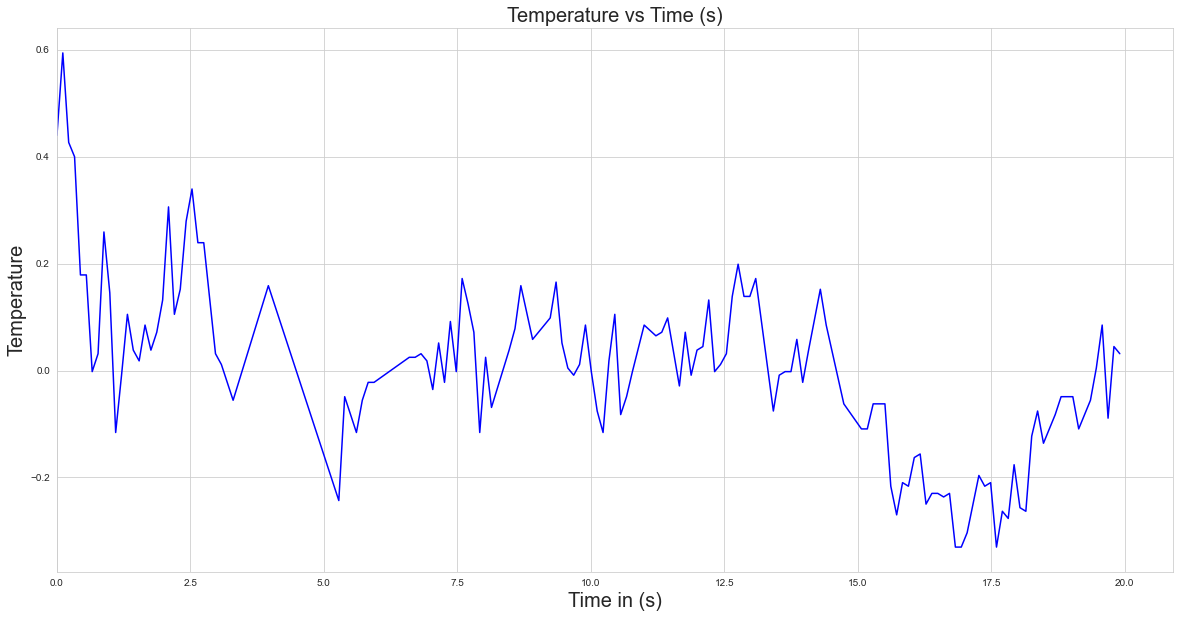

In [7]:
#plot temperature vs time graph
plt.figure(figsize = (20, 10))
plt.plot(t,amplitude,'b',label = 'Temperature vs Time')
plt.xlabel('Time in (s)',fontsize = 20)
plt.ylabel('Temperature',fontsize = 20)
plt.title('Temperature vs Time (s)',fontsize = 20)
plt.xlim(left = 0)
plt.show()

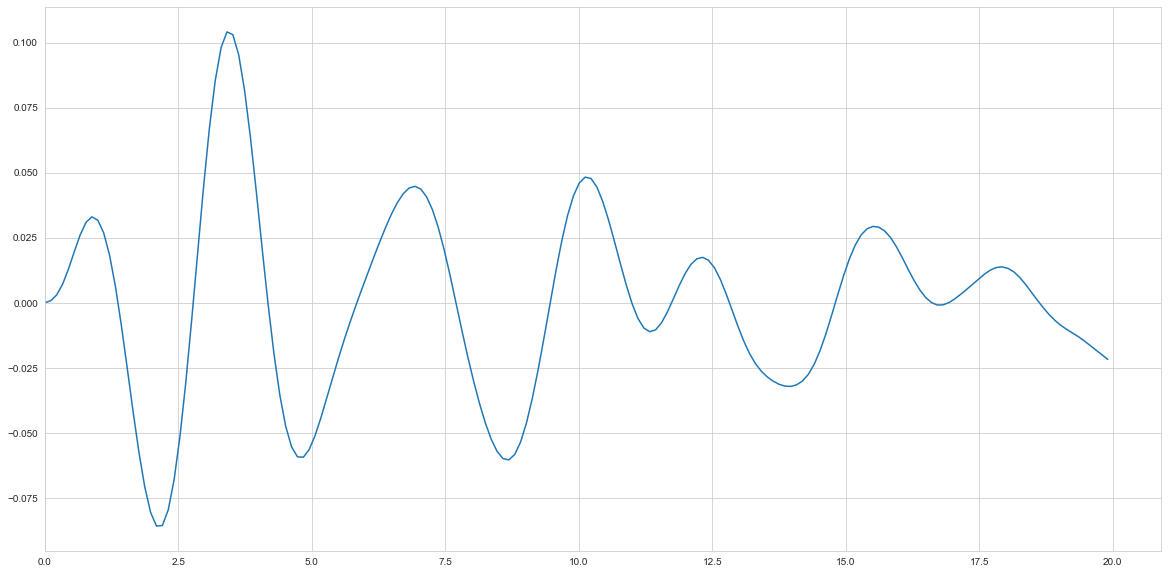

In [8]:
#create 3rd order butterworth filter to remove frequency below 0.2 and above 0.4
sos = signal.butter(3,[0.2,0.4],btype = 'bandpass',fs = fps,output ='sos')
# filter the amplitude signal
filtered = signal.sosfilt(sos, amplitude)
#ploting the filtered signal
plt.figure(figsize = (20, 10))
plt.plot(t,filtered)
plt.xlim(left = 0)
plt.show()

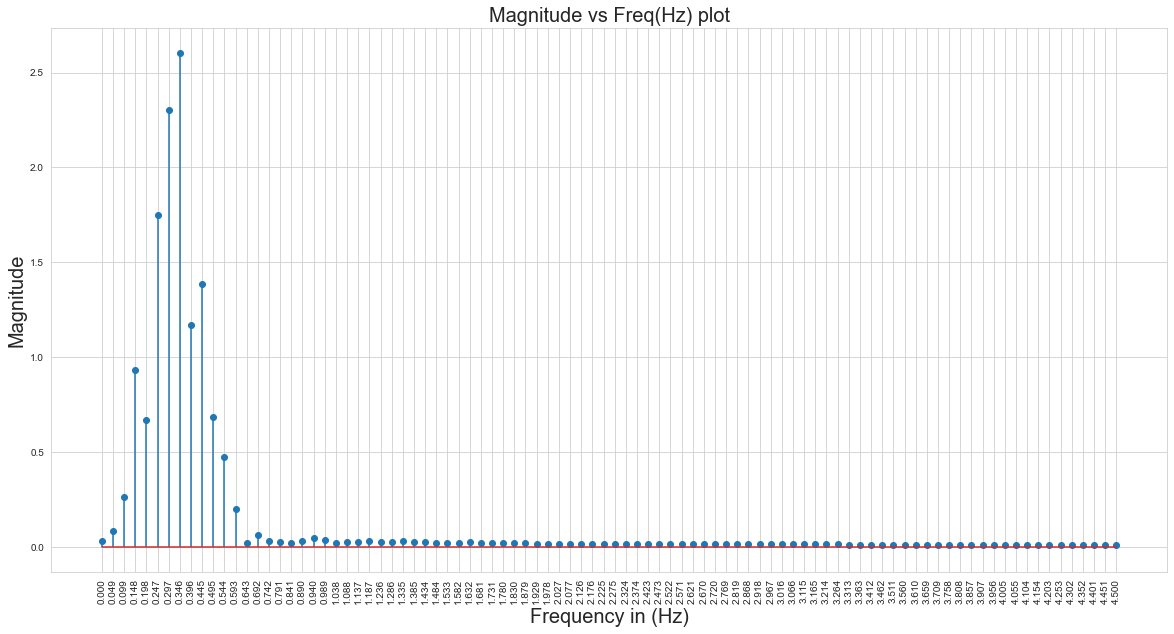

In [9]:
# calculating the fft tranformation of the filtered signal
yf = rfft(filtered)
xf = rfftfreq(len(filtered), 1 / fps)
plt.figure(figsize = (20, 10))
plt.stem(xf,np.abs(yf))
plt.xticks(xf,rotation=90)
#plt.stem(xf[(xf > 0.2) & (xf < 0.33)], np.abs(yf)[(xf > 0.2) & (xf < 0.33)])
#plt.xticks(xf[(xf > 0.2) & (xf < 0.33)],rotation = 90)
plt.xlabel('Frequency in (Hz)',fontsize = 20)
plt.ylabel('Magnitude',fontsize = 20)
plt.title('Magnitude vs Freq(Hz) plot',fontsize = 20)
plt.show()